In [1]:
# Import libraries 
import networkx as nx
import random
from typing import Tuple, Any
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

In [14]:
def contract_edge(g: nx.Graph, edge: Tuple[Any, Any]):
    """
    @g: the graph 
    @edge: the edge that needs to be contracted
    Returns: new graph with contracted edge, 
    taking weight into consideration
    Remark: we do not sample an edge wrt to weight size (not conform to original algo)
    """
    # Create a copy the graph (expensive)
    h = g.copy()
    
    # Identify the nodes relative to the edge 
    u, v = edge
    
    # Keep track of the previous contractions 
    contraction = []
    contraction += g.nodes(data=True)[u]['contraction']
    contraction += g.nodes(data=True)[v]['contraction']
    
    # Compute new edge for the edges that requires it 
    new_edges = defaultdict(lambda: 0)
    for x, y, d in g.edges([u, v], data=True):
        if y != u and y != v:
            new_edges[(u, y)] += d['weight']
    
    # Remove this two nodes
    h.remove_nodes_from([u, v])
    
    # Create new node that keeps track of the contractions
    h.add_node(u, contraction=contraction)
    
    # Add weights
    h.add_weighted_edges_from([(k[0], k[1], w) for k, w in new_edges.items()])
    
    return h


def karger_mincut(g: nx.Graph, n_iter: int):
    """
    @g: graph
    @n_iter: number of times the algo is applied
    Returns: cut applied and its value. 
    """
    best_graph = None
    best_cut = None
    
    # Repeat several times 
    for _ in tqdm(range(n_iter)):
        h = g.copy()
        start_time = time.time()
        while h.number_of_nodes() > 2:
            print("\r", h.number_of_nodes(), h.number_of_edges(), end="")
            # Choose an edge uniformly at randomly 
            e = random.choice(list(h.edges))
            # Add constraint on target and source node
            un = set(h.nodes(data=True)[e[0]]['contraction']).union(h.nodes(data=True)[e[1]]['contraction'])
            if set(['target','source']).issubset(set(un)):
                pass
            else: 
                h = contract_edge(h, e)
        end_time = time.time()
        total_time = end_time - start_time
        print("Time: ", total_time)   
        
        # Store the best cut among iterations 
        cut = h.get_edge_data(*list(h.edges)[0])['weight']
        if best_cut is None or cut < best_cut:
            best_cut = cut
            best_graph = h
    print("Min-cut :", best_cut)
    
    # Print the components of the best cut
    for node in best_graph.nodes(data=True):
        print(node)
        
        
def get_nid(x, y, side):
    """
    Define node id for the pixel (x,y)
    """
    return x + side * y


def draw_random_graph(side):
    """
    @side: dimension of the graph 
    Create a graph that looks like our picture graph
    """
    
    # Initialise graph 
    example = nx.Graph()
    pixel_nodes = []

    # Add node with special id - (#: size x size)
    for x in range(side):
        for y in range(side):
            nid = get_nid(x, y, side)
            example.add_node(nid, contraction=[nid])
            pixel_nodes.append(nid)
            if x > 0:
                example.add_edge(nid, get_nid(x - 1, y, side), weight=1)
            if y > 0:
                example.add_edge(nid, get_nid(x, y - 1, side), weight=1)
        
    # Add source and target node 
    example.add_node('source', contraction=['source'])
    example.add_node('target', contraction=['target'])
    # Link these two nodes to all nodes (except themselves)
    for pnode in pixel_nodes:
        example.add_edge('source', pnode, weight=1)
        example.add_edge(pnode, 'target', weight=1)
            
    #nx.draw(example)
    #plt.show()
    return example


 3 3Time:  0.016816139221191406

Min-cut : 11
(8, {'contraction': [8, 'target']})
(5, {'contraction': [5, 4, 7, 2, 1, 'source', 0, 3, 6]})


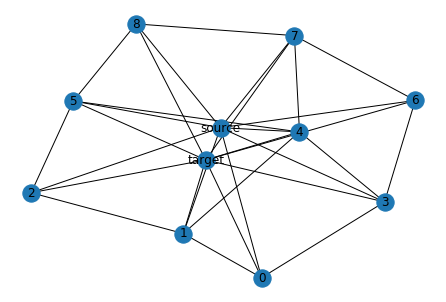

In [3]:
# APPLICATION

example = draw_random_graph(3) 
#pos = nx.spring_layout(example, iterations=10)
nx.draw(example, with_labels=True)
karger_mincut(example, 1)

In [96]:
# MULTIGRAPH METHOD 

def create_graph(h,w):
    """
    @h: height of the image
    @w: width of the image 
    Create an adapted graph for image segmentation task
    """

    # required graph format for pictures 
    G = nx.grid_2d_graph(h, w, create_using = nx.MultiGraph()) 

    # Add source and target nodes
    G.add_nodes_from(['target','source'])
    for node in list(G.nodes):   
        if node not in ['source', 'target']:
            G.add_edge(node, 'target')
            G.add_edge(node, 'source')

    # Assign weights to graph above 
    weights = list(np.random.random(G.number_of_edges())) # random weight on edges 

    # Add weights to each edge
    list_of_nodes = list(G.nodes()) # keep a list of nodes
    list_edges = [] # keep a list of edges
    for i,e in enumerate(G.edges()):
        G[e[0]][e[1]][0]['weight'] = weights[i] # multigraph
        #G[e[0]][e[1]]['weight'] = weights[i] # graph 
        list_edges.append(e)
        
    # Relabel nodes    
    mapping = {}
    for node in list(G.nodes()):
        if node == 'source':
            mapping[node] = node
        elif node == 'target':
            mapping[node] = node
        else:
            mapping[node] =  get_nid(node[0], node[1], h)
    G = nx.relabel_nodes(G, mapping)
    
    # Create same graph but with contraction on nodes
    H = nx.MultiGraph()
    for node in list(G.nodes()):
        H.add_node(node, contraction= [node])
    for edge in list(G.edges.data()):
        H.add_edge(edge[0], edge[1], weight = edge[2]['weight'])
    
    return H 




In [106]:
def contract_edge_bis(g: nx.Graph, edge: Tuple[Any, Any]):
    """
    @g: the graph 
    @edge: the edge that needs to be contracted
    Returns: new graph with contracted edge, 
    taking weight into consideration
    """
    # Create a copy the graph (expensive)
    h = g.copy()
    
    # Identify the nodes relative to the edge 
    u, v = edge
    
    # Keep track of the previous contractions 
    contraction = []
    contraction += g.nodes(data=True)[u]['contraction']
    print(contraction)
    print('new', g.nodes(data=True)[v]['contraction'])
    contraction += g.nodes(data=True)[v]['contraction']
    
    # Compute new edge for the edges that requires it 
    # new_edges = defaultdict(lambda: 0)
    # for x, y, d in g.edges([u, v], data=True):
    #    if y != u and y != v:
    #        new_edges[(u, y)] += d['weight']
    
    # Compute new edge for the edges that requires it 
    new_edges = defaultdict(lambda: 0)
    for x,y,d in G.edges.data():
        if x == u or x == v: 
            new_edges[(u, y)] += d['weight']
        if y == u or y == v: 
            new_edges[(u, x)] += d['weight']
            
    # Remove this two nodes
    h.remove_nodes_from([u, v])
    
    # Create new node that keeps track of the contractions
    h.add_node(u, contraction=contraction)
    
    # Add weights
    h.add_weighted_edges_from([(k[0], k[1], w) for k, w in new_edges.items()])
    
    return h


def karger_mincut_bis(g: nx.Graph, n_iter: int):
    best_graph = None
    best_cut = None
    for _ in range(n_iter):
        h = g.copy()
        while h.number_of_nodes() > 2:
            #print("\r", h.number_of_nodes(), h.number_of_edges(), end="")
            e = random.choice(list(h.edges()))
            h = contract_edge_bis(h, e)
        
        cut = h.get_edge_data(*list(h.edges)[0])['weight']
        if best_cut is None or cut < best_cut:
            best_cut = cut
            best_graph = h
    print("Min-cut:", best_cut)
    for node in best_graph.nodes(data=True):
        print(node)

In [105]:
G.nodes.data()

NodeDataView({0: {'contraction': [0]}, 4: {'contraction': [4]}, 8: {'contraction': [8]}, 12: {'contraction': [12]}, 1: {'contraction': [1]}, 5: {'contraction': [5]}, 9: {'contraction': [9]}, 13: {'contraction': [13]}, 2: {'contraction': [2]}, 6: {'contraction': [6]}, 10: {'contraction': [10]}, 14: {'contraction': [14]}, 3: {'contraction': [3]}, 7: {'contraction': [7]}, 11: {'contraction': [11]}, 15: {'contraction': [15]}, 'target': {'contraction': ['target']}, 'source': {'contraction': ['source']}})

In [47]:
list(G.edges.data())[0][2]['weight']

0.3425780692347883

In [107]:
# APPLICATION 
G = create_graph(4,4)
karger_mincut_bis(G, 1)

[14]
new ['target']
[5]
new [9]
[3]
new [14, 'target']
[4]
new ['source']
[4, 'source']


KeyError: 'contraction'

In [72]:
G.nodes(data=True)[0]['contraction']

0

In [78]:
l

[0, 1]

In [77]:
l.append(G.nodes(data=True)[1]['contraction'])

In [ ]:
def basix_karger_mincut(g):
    source = []
    while g.number_of_nodes() > 2: 
        e = random.choice(list(g.edges))
        g = nx.contracted_edge(g, e, self_loops=False)
    return g, source

graph, l = karger_mincut(g = H)

In [ ]:
elarge = [(u, v) for (u, v, d) in g1.edges(data=True) if d['weight'] > 4]
esmall = [(u, v) for (u, v, d) in g1.edges(data=True) if d['weight'] <= 4]

nx.set_node_attributes(G, 'name', G.nodes())